# LLM Variance using PCA and Trace of Covariance Matrix


In [9]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain.schema.messages import SystemMessage
import yaml
import os
import json
import pandas as pd
from openai import OpenAI


# Set up your OpenAI API key
with open('openai.yaml', 'r') as f:
    config = yaml.safe_load(f)

os.environ['OPENAI_API_KEY'] = config['openai_key']

llm = ChatOpenAI()
client = OpenAI()

## Data Generation and Embedding

In [3]:
chat_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(
            content=('''This is an action in the Sustainable Farming Incentive (SFI) scheme: expanded offer for 2024. You must read the SFI scheme information to understand the scheme rules and how to apply. 3 years £257 per pond per year, with a maximum of 3 ponds per hectare (ha) This action’s aim is that there’s a pond containing clear and clean water with: The purpose of this is to: You can do this action on eligible ponds located on land that’s: An eligible pond for this action must be: The following ponds are not eligible for this action: Not applicable. You’ll enter the number of ponds. This action is static. This means you must do it at the same location each year of this action’s duration. You must manage the pond in a way that can reasonably be expected to achieve this action’s aim, including: You must not: You must do this action from its start date, throughout each year of its 3-year duration. It’s up to you how you do this action, as long as you: Advice to help you do this action will be published before applications are fully launched from summer 2024. It will not be part of this action’s requirements. You must keep evidence to show what you’ve done to complete this action, such as: If it’s not clear that you’ve done this action in a way that could reasonably be expected to achieve its aim, we may ask for this evidence. You must supply the evidence if we ask for it. You can do the following actions or options on the same area in a land parcel as this action. Some actions or options can only be done on the same area if they’re done at a different time of year to this action. For example, winter cover followed by a summer companion crop. Read ‘What to do’ and ‘When to do it’ to find out when this action must be done. If an action or option cannot be located on the same area, you may be able to do it on a different area in the same land parcel. Read section 6. ‘Eligible land in other funding schemes’ for more information. Don’t include personal or financial information like your National Insurance number or credit card details.''')
        ),

        HumanMessagePromptTemplate.from_template(
            """{question}"""
            ),
    ]
)



llm_responses = [llm.invoke(chat_template.format_messages(question='how much can I get for my 3 ponds')).content for _ in range(100)]
llm_responses[:10]

["For 3 ponds, you can receive £257 per pond per year, with a maximum of 3 ponds per hectare (ha) under the Sustainable Farming Incentive (SFI) scheme's expanded offer for 2024. This means for each of the 3 ponds on your land, you would be eligible to receive £257 per pond per year for the duration of the scheme, which is 3 years.",
 'For 3 ponds, you can receive £257 per pond per year for a duration of 3 years. This means you can receive a total payment of £771 per pond over the 3-year period.',
 "For your 3 ponds, you can receive £257 per pond per year, with a maximum of 3 ponds per hectare (ha) under the Sustainable Farming Incentive (SFI) scheme's expanded offer for 2024. So, for each pond over the 3-year duration of the action, you could receive a total of £771 (£257 x 3 years) per pond.",
 'You can receive £257 per pond per year for a maximum of 3 ponds per hectare. So, for your 3 ponds, you could potentially receive a total of £771 per year (£257 x 3 ponds). This payment would b

In [ ]:
#Get the embedding vectors from OAI API
def fetch_oai_embeddings(input_strings:list,
                         embedding_model: str,
                         oai_client:OpenAI)-> list:

    responses = []

    #Get the embedding values for each input in your list
    #Probably a way to do this async
    for input_string in input_strings:
        response = oai_client.embeddings.create(
            input=input_string,
            model=embedding_model)
        responses.append(response.data[0].embedding)

    return responses

In [12]:
# retrieve the embeddings for the responses
response_embeddings = fetch_oai_embeddings(llm_responses, 'text-embedding-ada-002', client)

## Determine Correct Number of Principal Components

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca_fit = pca.fit(response_embeddings)

<Axes: xlabel='Principal Component', ylabel='Explained Variance'>

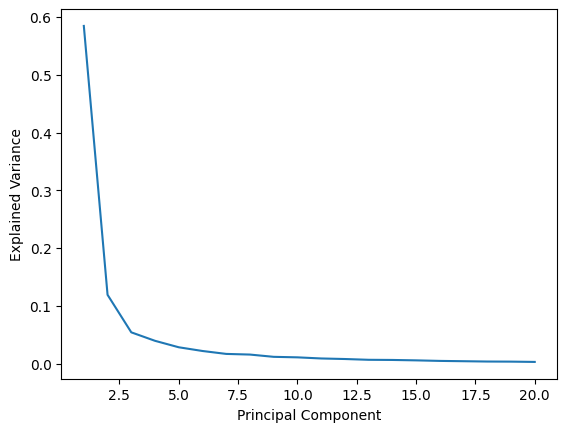

In [39]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(pca.explained_variance_ratio_).reset_index()
df['index'] +=1
df = df.rename(columns={"index": "Principal Component", 0: "Explained Variance"})
sns.lineplot(data=df, x='Principal Component', y='Explained Variance', markers=True)

Let's use the top 5 principal Components based off the Scree Plot

## Data Processing

In [42]:
import numpy as np

def calculate_response_variance_from_embeddings(response_embeddings):
    # Apply PCA
    pca = PCA(n_components=5)
    pca_fit = pca.fit(response_embeddings)

    # Variances (eigenvalues) from PCA
    explained_variance = pca.explained_variance_

    # Calculate the trace of the covariance matrix (sum of explained variances)
    trace_covariance_matrix = np.sum(explained_variance)

    return trace_covariance_matrix

## Generate Workflow and Test

The below cell takes an age to process

In [45]:
gpt3_1106_model = ChatOpenAI(model='gpt-3.5-turbo-1106')
gpt3_0125_model = ChatOpenAI(model='gpt-3.5-turbo-0125')
gpt4_0613_model = ChatOpenAI(model='gpt-4-0613')
gpt4_1106_preview_model = ChatOpenAI(model='gpt-4-1106-preview')
gpt4_0904_turbo_model = ChatOpenAI(model='gpt-4-turbo-2024-04-09')
gpt4o_0718_mini_model = ChatOpenAI(model='gpt-4o-mini-2024-07-18')
gpt4o_0806_model = ChatOpenAI(model='gpt-4o-2024-08-06')
gpt4o_0513_model = ChatOpenAI(model='gpt-4o-2024-05-13')

gpt3_1106_responses = [gpt3_1106_model.invoke(chat_template.format_messages(question='how much can I get for my 3 ponds')).content for _ in range(100)]
gpt3_0125_responses = [gpt3_0125_model.invoke(chat_template.format_messages(question='how much can I get for my 3 ponds')).content for _ in range(100)]
gpt4_0613_responses = [gpt4_0613_model.invoke(chat_template.format_messages(question='how much can I get for my 3 ponds')).content for _ in range(100)]
gpt4_1106_preview_responses = [gpt4_1106_preview_model.invoke(chat_template.format_messages(question='how much can I get for my 3 ponds')).content for _ in range(100)]
gpt4_0904_turbo_responses = [gpt4_0904_turbo_model.invoke(chat_template.format_messages(question='how much can I get for my 3 ponds')).content for _ in range(100)]
gpt4o_0718_mini_responses = [gpt4o_0718_mini_model.invoke(chat_template.format_messages(question='how much can I get for my 3 ponds')).content for _ in range(100)]
gpt4o_0806_responses = [gpt4o_0806_model.invoke(chat_template.format_messages(question='how much can I get for my 3 ponds')).content for _ in range(100)]
gpt4o_0513_responses = [gpt4o_0513_model.invoke(chat_template.format_messages(question='how much can I get for my 3 ponds')).content for _ in range(100)]

gpt3_1106_embeddings = fetch_oai_embeddings(gpt3_1106_responses, 'text-embedding-ada-002', client)
gpt3_0125_embeddings = fetch_oai_embeddings(gpt3_0125_responses, 'text-embedding-ada-002', client)
gpt4_0613_embeddings = fetch_oai_embeddings(gpt4_0613_responses, 'text-embedding-ada-002', client)
gpt4_1106_preview_embeddings = fetch_oai_embeddings(gpt4_1106_preview_responses, 'text-embedding-ada-002', client)
gpt4_0904_turbo_embeddings = fetch_oai_embeddings(gpt4_0904_turbo_responses, 'text-embedding-ada-002', client)
gpt4o_0718_mini_embeddings = fetch_oai_embeddings(gpt4o_0718_mini_responses, 'text-embedding-ada-002', client)
gpt4o_0806_embeddings = fetch_oai_embeddings(gpt4o_0806_responses, 'text-embedding-ada-002', client)
gpt4o_0513_embeddings = fetch_oai_embeddings(gpt4o_0513_responses, 'text-embedding-ada-002', client)



In [75]:
embedding_variance = []

for embeddings in [gpt3_1106_embeddings, gpt3_0125_embeddings, gpt4_0613_embeddings, gpt4_1106_preview_embeddings, gpt4_0904_turbo_embeddings, gpt4o_0718_mini_embeddings, gpt4o_0806_embeddings, gpt4o_0513_embeddings]:
    embedding_variance.append(calculate_response_variance_from_embeddings(embeddings))

In [76]:
df_variance = pd.DataFrame(embedding_variance)
df_variance = df_variance.rename(columns={0: 'Sum of Explained Variance'})
df_variance['Model'] = ["gpt3_1106", "gpt3_0125", "gpt4_0613", "gpt4_1106_preview", "gpt4_0904_turbo", "gpt4o_0718_mini", "gpt4o_0806", "gpt4o_0513"]
df_variance['Family'] = ["GPT-3.5Turbo", "GPT-3.5Turbo", "GPT-4", "GPT-4Turbo", "GPT-4Turbo", "GPT-4oMini", "GPT4o", "GPT4o"]
df_variance['Age Ordinance'] = [2,3,1,2,4,6,6,5]

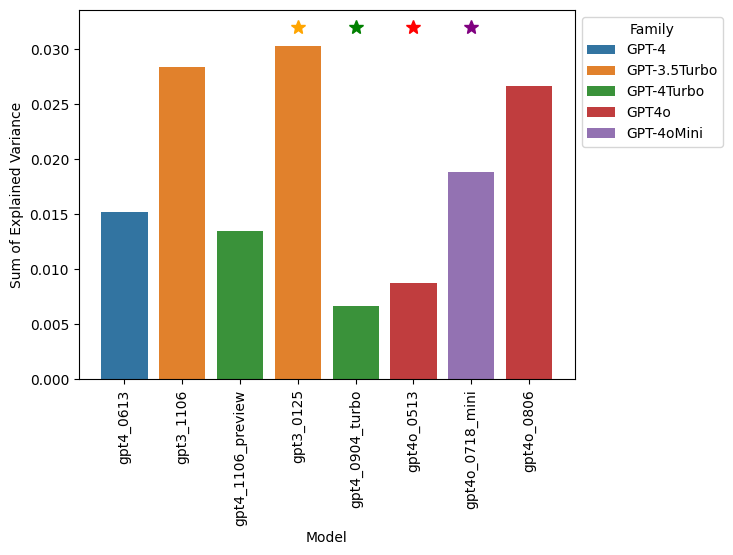

In [81]:
import matplotlib.pyplot as plt

ax = sns.barplot(data=df_variance.sort_values(by='Age Ordinance'), x='Model', y='Sum of Explained Variance', hue='Family')

plt.xticks(rotation=90)
ax.plot('gpt4o_0513', 0.032, "*", markersize=10, color="r")
ax.plot('gpt4_0904_turbo', 0.032, "*", markersize=10, color="green")
ax.plot('gpt4o_0718_mini', 0.032, "*", markersize=10, color="purple")
ax.plot('gpt3_0125', 0.032, "*", markersize=10, color="orange")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Let's Compare Prompts

In [84]:
clear_prompt = 'Describe the process of photosynthesis in plants, focusing specifically on the roles of sunlight, carbon dioxide, and chlorophyll.'
unclear_prompt = 'Talk about plants and their importance.'

clear_responses = [llm.invoke(clear_prompt).content for _ in range(100)]
unclear_responses = [llm.invoke(clear_prompt).content for _ in range(100)]

([0, 1], [Text(0, 0, 'Clear'), Text(1, 0, 'Unclear')])

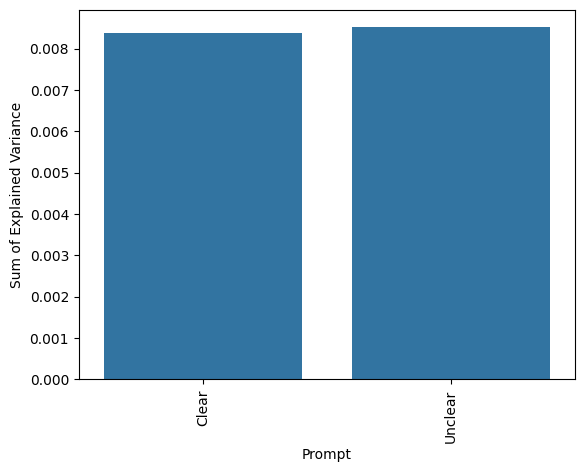

In [87]:
clear_embeddings = fetch_oai_embeddings(clear_responses, 'text-embedding-ada-002', client)
unclear_embeddings = fetch_oai_embeddings(unclear_responses, 'text-embedding-ada-002', client)

clarity_embedding_variance = []
for embeddings in [clear_embeddings, unclear_embeddings]:
    clarity_embedding_variance.append(calculate_response_variance_from_embeddings(embeddings))

df_clarity_variance = pd.DataFrame(clarity_embedding_variance)
df_clarity_variance = df_clarity_variance.rename(columns={0: 'Sum of Explained Variance'})
df_clarity_variance['Prompt'] = ["Clear", "Unclear"]

ax = sns.barplot(data=df_clarity_variance, x='Prompt', y='Sum of Explained Variance')
plt.xticks(rotation=90)

In [139]:
# Apply PCA
pca = PCA(n_components=100) #n_components = min(n_samples, n_features)
pca_fit = pca.fit(np.array(clear_embeddings))

# Variances (eigenvalues) from PCA
explained_variance = pca.explained_variance_

<Axes: xlabel='Principal Component', ylabel='Explained Variance'>

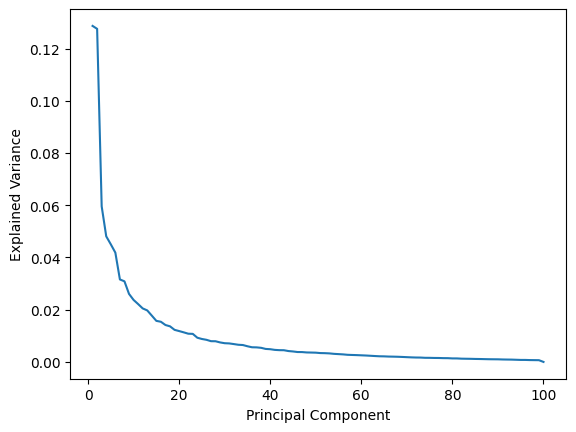

In [136]:
df = pd.DataFrame(pca.explained_variance_ratio_).reset_index()
df['index'] +=1
df = df.rename(columns={"index": "Principal Component", 0: "Explained Variance"})
sns.lineplot(data=df, x='Principal Component', y='Explained Variance', markers=True)

## Dynamically Extract Number of Principal Components

Rather than pick 5 or 100 components. It would be preferable to select a dynamic number of components which explain a set %age of teh variance in the dataset, say 80%.

Let's first convert the explained variance scree plot into an pdf/cdf plot

<Axes: xlabel='Principal Component', ylabel='Cumulative Variance'>

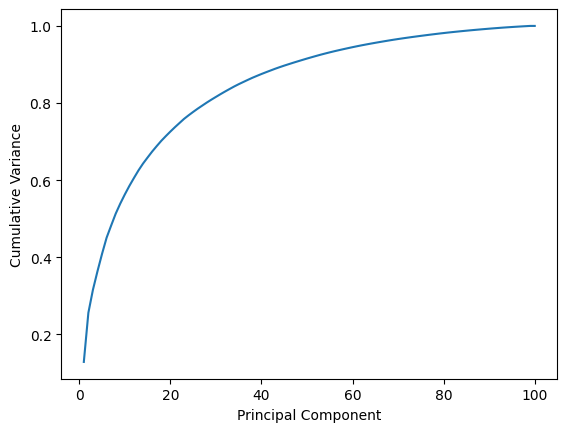

In [143]:
# convert explained variance array into a cumulative explained variance array
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
df = pd.DataFrame(cumsum_variance).reset_index()
df['index'] +=1
df = df.rename(columns={"index": "Principal Component", 0: "Cumulative Variance"})
sns.lineplot(data=df, x='Principal Component', y='Cumulative Variance', markers=True)

In [152]:
cumsum_variance[sum(cumsum_variance < 0.9) - 1]

0.8970638723928809

In [153]:
sum(cumsum_variance < 0.9) - 1

44

In [166]:
def allofthemaths(embeddings):

    # Apply PCA
    pca = PCA() #n_components = min(n_samples, n_features)
    pca_fit = pca.fit(np.array(embeddings))

    # Variances (eigenvalues) from PCA
    cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
    n_useful_components = sum(cumsum_variance < 0.9) - 1

    # Variances (eigenvalues) from PCA
    explained_variance = pca.explained_variance_[n_useful_components]

    # Calculate the trace of the covariance matrix (sum of explained variances)
    trace_covariance_matrix = np.sum(explained_variance)

    return n_useful_components, trace_covariance_matrix

In [171]:
allofthemaths(clear_embeddings)[1] /  allofthemaths(unclear_embeddings)[1]

0.9552098664545997

In [168]:
allofthemaths(unclear_embeddings)

(43, 8.593456886247857e-05)

In [174]:
unrelated_prompt = 'How can I combine 18 quarks together and what will that let me do?'
unrelated_responses = [llm.invoke(unrelated_prompt).content for _ in range(100)]
print(unrelated_responses[:10])
unrelated_embeddings = fetch_oai_embeddings(unrelated_responses, 'text-embedding-ada-002', client)


['Combining 18 quarks together would be a highly complex and challenging task, as quarks are elementary particles that are typically found in groups of three to form protons and neutrons. However, theoretically, it is possible to combine 18 quarks together to form a highly unstable and exotic particle known as a pentaquark.\n\nPentaquarks have been observed in high-energy particle collisions in particle accelerators, but they are extremely short-lived and difficult to study. If you were able to successfully combine 18 quarks together to create a stable pentaquark, it could potentially lead to new discoveries in particle physics and provide insights into the fundamental forces and interactions that govern the universe.\n\nHowever, creating and studying such a complex particle would require advanced technology and infrastructure, such as a high-energy particle accelerator. Additionally, the practical applications of manipulating and studying pentaquarks are still largely unknown, as they

In [175]:
print(allofthemaths(clear_embeddings))
print(allofthemaths(unclear_embeddings))
print(allofthemaths(unrelated_embeddings))

allofthemaths(clear_embeddings)[1] / allofthemaths(unrelated_embeddings)[1]

(44, 8.208554804696176e-05)
(43, 8.593456886247857e-05)
(42, 0.00018586738230940613)


0.44163503583601976

In [105]:
deterministic_lmm= ChatOpenAI(model='gpt-4o', seed=1337, temperature=0.00000000000001, top_p=0.00000000000001, logprobs=True, top_logprobs=1, verbose=True)

llm_responses = [deterministic_lmm.invoke(chat_template.format_messages(question='how much can I get for my 3 ponds')).content for _ in range(10)]
llm_responses

["Under the Sustainable Farming Incentive (SFI) scheme's expanded offer for 2024, you can receive £257 per pond per year. If you have 3 ponds, the calculation would be as follows:\n\n\\[ 3 \\text{ ponds} \\times £257 \\text{ per pond per year} = £771 \\text{ per year} \\]\n\nSince the action duration is 3 years, the total amount you can receive over the 3-year period would be:\n\n\\[ £771 \\text{ per year} \\times 3 \\text{ years} = £2,313 \\]\n\nTherefore, you can get a total of £2,313 for your 3 ponds over the 3-year duration of the action.",
 "Under the Sustainable Farming Incentive (SFI) scheme's expanded offer for 2024, you can receive £257 per pond per year. If you have 3 ponds, the calculation would be as follows:\n\n\\[ 3 \\text{ ponds} \\times £257 \\text{ per pond per year} = £771 \\text{ per year} \\]\n\nSince the action's duration is 3 years, the total amount you can receive over the 3-year period would be:\n\n\\[ £771 \\text{ per year} \\times 3 \\text{ years} = £2,313 \\]